## Multilabel Classification of Reviews 

Dataset Source: https://www.kaggle.com/datasets/debarshichanda/goemotions

##### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

import transformers
from transformers import DataCollatorForSeq2Seq, AutoTokenizer, DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer, set_seed

import datasets
from datasets import Dataset, DatasetDict

import evaluate

import torch

!git lfs install

NOTE: Redirects are currently not supported in Windows or MacOs.


Git LFS initialized.


##### Display Version of Relevant Libraries

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("NumPy:".rjust(15), np.__version__)
print("Torch:".rjust(15), transformers.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.12
        Pandas: 1.5.0
         NumPy: 1.23.3
         Torch: 4.26.1
  Transformers: 4.26.1
      Datasets: 2.8.0
      Evaluate: 0.2.2


##### Ingest Data & Drop Unnecessary Features

In [3]:
parent_dir = "/Users/briandunn/Desktop/nlp_ds/ml clf/data"

df = pd.read_csv(os.path.join(parent_dir, "goemotions_1.csv"))

df.drop(columns=["id", 
                 "author", 
                 "subreddit", 
                 "link_id", 
                 "parent_id", 
                 "created_utc", 
                 "rater_id", 
                 "example_very_unclear"
                 ], 
        inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            70000 non-null  object
 1   admiration      70000 non-null  int64 
 2   amusement       70000 non-null  int64 
 3   anger           70000 non-null  int64 
 4   annoyance       70000 non-null  int64 
 5   approval        70000 non-null  int64 
 6   caring          70000 non-null  int64 
 7   confusion       70000 non-null  int64 
 8   curiosity       70000 non-null  int64 
 9   desire          70000 non-null  int64 
 10  disappointment  70000 non-null  int64 
 11  disapproval     70000 non-null  int64 
 12  disgust         70000 non-null  int64 
 13  embarrassment   70000 non-null  int64 
 14  excitement      70000 non-null  int64 
 15  fear            70000 non-null  int64 
 16  gratitude       70000 non-null  int64 
 17  grief           70000 non-null  int64 
 18  joy   

##### Visual: Histogram of Article Abstract's Word Lengths

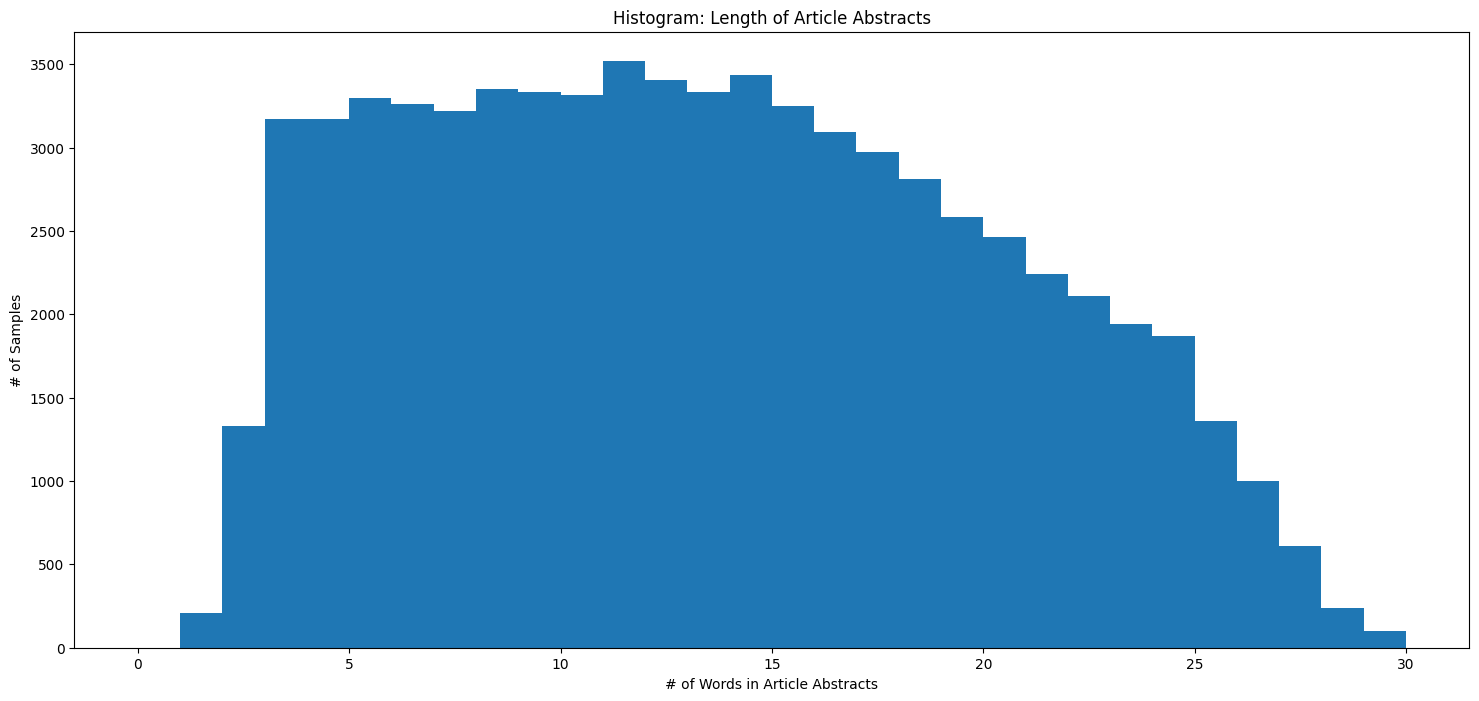

The maximum length of Article Abstracts (in words) is 33 words.


In [4]:
df['text_length'] = df['text'].str.split().str.len()

n_bin=30
df.hist('text_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Article Abstracts')
plt.xlabel('# of Words in Article Abstracts')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of Article Abstracts (in words) is {max(df['text_length'])} words.")

##### Data Preprocessing

In [5]:
upper_limit=31

df = df[df['text_length'] < upper_limit]

df = df.drop(columns=["text_length"])

df.reset_index(drop=True, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69996 entries, 0 to 69995
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            69996 non-null  object
 1   admiration      69996 non-null  int64 
 2   amusement       69996 non-null  int64 
 3   anger           69996 non-null  int64 
 4   annoyance       69996 non-null  int64 
 5   approval        69996 non-null  int64 
 6   caring          69996 non-null  int64 
 7   confusion       69996 non-null  int64 
 8   curiosity       69996 non-null  int64 
 9   desire          69996 non-null  int64 
 10  disappointment  69996 non-null  int64 
 11  disapproval     69996 non-null  int64 
 12  disgust         69996 non-null  int64 
 13  embarrassment   69996 non-null  int64 
 14  excitement      69996 non-null  int64 
 15  fear            69996 non-null  int64 
 16  gratitude       69996 non-null  int64 
 17  grief           69996 non-null  int64 
 18  joy   

##### Create List of Labels & Dictionaries for Converting Between Strings & Integers

In [6]:
labels = [x for x in df.columns if x not in ['text']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
NUM_OF_LABELS = len(labels)

##### Convert Pandas DataFrame to Datasets & Split Dataset into Training/Testing/Evaluation Datasets

In [7]:
dataset = Dataset.from_pandas(df)

train_testEval = dataset.train_test_split(train_size=0.80)
test_eval = train_testEval['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)
ds['train'][25]

Training Dataset Shape: (55996, 29)
Testing Dataset Shape: (7000, 29)
Evaluation Dataset Shape: (7000, 29)


{'text': 'It could have been worse! All the chairs and table are still upright.',
 'admiration': 0,
 'amusement': 0,
 'anger': 0,
 'annoyance': 0,
 'approval': 0,
 'caring': 0,
 'confusion': 0,
 'curiosity': 0,
 'desire': 0,
 'disappointment': 0,
 'disapproval': 0,
 'disgust': 0,
 'embarrassment': 0,
 'excitement': 0,
 'fear': 0,
 'gratitude': 0,
 'grief': 0,
 'joy': 0,
 'love': 0,
 'nervousness': 0,
 'optimism': 0,
 'pride': 0,
 'realization': 0,
 'relief': 0,
 'remorse': 0,
 'sadness': 0,
 'surprise': 0,
 'neutral': 1}

#### Basic Values/Constants

In [8]:
set_seed = 42
NUM_OF_EPOCHS = 5

BATCH_SIZE = 64
LEARNING_RATE = 2e-5

MAX_LENGTH = int(round((upper_limit - 1) * 1.3, 0))
MODEL_CKPT = "distilbert-base-uncased"
MODEL_NAME = MODEL_CKPT + "-emotions_multilabel_clf"

METRIC_NAME = "f1"
DEVICE = torch.device("cpu")

print(f"This project will utilize the {DEVICE} to train and evaluate.")
print(f"This project will have a maximum length for the input text of {MAX_LENGTH} tokens.")

This project will utilize the cpu to train and evaluate.
This project will have a maximum length for the input text of 39 tokens.


##### Create Tokenizer

In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def data_preprocessor(examples):
	# take a batch of text
	text = examples["text"]
	# encode them
	encoded_data = tokenizer(text, padding="max_length", truncation=True, max_length=MAX_LENGTH)
	# add labels
	labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
	# create numpy array of shape (batch_size, num_labels)
	labels_matrix = np.zeros((len(text), len(labels)))
	# fill numpy array	
	for idx, label in enumerate(labels):
		labels_matrix[:, idx] = labels_batch[label]

	encoded_data["labels"] = labels_matrix.tolist()
  
	return encoded_data

##### Tokenize Dataset

In [10]:
encoded_ds = ds.map(data_preprocessor, batched=True, load_from_cache_file=False)
encoded_ds.set_format("torch")

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

##### Print Dataset Shapes to Make Sure Prepared for Later

In [11]:
print(f"The shape of the training dataset is: {encoded_ds['train'].shape}")
print(f"The shape of the testing dataset is: {encoded_ds['test'].shape}")
print(f"The shape of the evaluation dataset is: {encoded_ds['eval'].shape}")

The shape of the training dataset is: (55996, 32)
The shape of the testing dataset is: (7000, 32)
The shape of the evaluation dataset is: (7000, 32)


##### Define Model

In [12]:
model = (DistilBertForSequenceClassification.from_pretrained(MODEL_CKPT, 
                                                             num_labels=NUM_OF_LABELS, 
                                                             problem_type="multi_label_classification",
                                                             id2label=id2label,
                                                             label2id=label2id)
         ).to(DEVICE)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

##### Create Metrics Evaluation Function

In [13]:
def multi_label_metrics(predictions, 
                        labels, 
                        threshold=0.5):
    '''
    This function calculates & returns metrics 
    for a multilabel classification analysis.
    '''
    
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return metrics as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    
    preds = preds[0] if isinstance(preds, 
                    tuple) else preds
    results = multi_label_metrics(
                    predictions=preds, 
                    labels=labels)
    return results

##### Define Training Arguments

In [14]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_OF_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    load_best_model_at_end=True,
    metric_for_best_model=METRIC_NAME,
    greater_is_better=True,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_first_step=True,
    push_to_hub=True
)

##### Instantiate Trainer

In [15]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Cloning https://huggingface.co/DunnBC22/distilbert-base-uncased-emotions_multilabel_clf into local empty directory.


##### Train Model

In [16]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: relief, annoyance, disgust, joy, grief, pride, gratitude, optimism, approval, excitement, sadness, text, embarrassment, curiosity, desire, disappointment, disapproval, confusion, neutral, love, fear, admiration, surprise, caring, realization, anger, amusement, remorse, nervousness. If relief, annoyance, disgust, joy, grief, pride, gratitude, optimism, approval, excitement, sadness, text, embarrassment, curiosity, desire, disappointment, disapproval, confusion, neutral, love, fear, admiration, surprise, caring, realization, anger, amusement, remorse, nervousness are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be remove

A Jupyter Widget

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.7085, 'learning_rate': 1.9995428571428574e-05, 'epoch': 0.0}
{'loss': 0.2028, 'learning_rate': 1.7714285714285717e-05, 'epoch': 0.57}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: relief, annoyance, disgust, joy, grief, pride, gratitude, optimism, approval, excitement, sadness, text, embarrassment, curiosity, desire, disappointment, disapproval, confusion, neutral, love, fear, admiration, surprise, caring, realization, anger, amusement, remorse, nervousness. If relief, annoyance, disgust, joy, grief, pride, gratitude, optimism, approval, excitement, sadness, text, embarrassment, curiosity, desire, disappointment, disapproval, confusion, neutral, love, fear, admiration, surprise, caring, realization, anger, amusement, remorse, nervousness are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7000
  Batch size = 64


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-emotions_multilabel_clf/checkpoint-875
Configuration saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-875/config.json
Model weights saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-875/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-875/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-875/special_tokens_map.json


{'eval_loss': 0.12688367068767548, 'eval_f1': 0.19987636513496806, 'eval_roc_auc': 0.55729863362581, 'eval_accuracy': 0.11442857142857144, 'eval_runtime': 581.5027, 'eval_samples_per_second': 12.038, 'eval_steps_per_second': 0.189, 'epoch': 1.0}


tokenizer config file saved in distilbert-base-uncased-emotions_multilabel_clf/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-emotions_multilabel_clf/special_tokens_map.json
Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


{'loss': 0.1323, 'learning_rate': 1.542857142857143e-05, 'epoch': 1.14}
{'loss': 0.1221, 'learning_rate': 1.3142857142857145e-05, 'epoch': 1.71}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: relief, annoyance, disgust, joy, grief, pride, gratitude, optimism, approval, excitement, sadness, text, embarrassment, curiosity, desire, disappointment, disapproval, confusion, neutral, love, fear, admiration, surprise, caring, realization, anger, amusement, remorse, nervousness. If relief, annoyance, disgust, joy, grief, pride, gratitude, optimism, approval, excitement, sadness, text, embarrassment, curiosity, desire, disappointment, disapproval, confusion, neutral, love, fear, admiration, surprise, caring, realization, anger, amusement, remorse, nervousness are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7000
  Batch size = 64


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-emotions_multilabel_clf/checkpoint-1750
Configuration saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-1750/config.json
Model weights saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-1750/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-1750/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-1750/special_tokens_map.json


{'eval_loss': 0.11836204677820206, 'eval_f1': 0.281467365412101, 'eval_roc_auc': 0.5871117222393081, 'eval_accuracy': 0.176, 'eval_runtime': 581.4761, 'eval_samples_per_second': 12.038, 'eval_steps_per_second': 0.189, 'epoch': 2.0}


tokenizer config file saved in distilbert-base-uncased-emotions_multilabel_clf/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-emotions_multilabel_clf/special_tokens_map.json


{'loss': 0.1172, 'learning_rate': 1.0857142857142858e-05, 'epoch': 2.29}
{'loss': 0.1139, 'learning_rate': 8.571428571428571e-06, 'epoch': 2.86}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: relief, annoyance, disgust, joy, grief, pride, gratitude, optimism, approval, excitement, sadness, text, embarrassment, curiosity, desire, disappointment, disapproval, confusion, neutral, love, fear, admiration, surprise, caring, realization, anger, amusement, remorse, nervousness. If relief, annoyance, disgust, joy, grief, pride, gratitude, optimism, approval, excitement, sadness, text, embarrassment, curiosity, desire, disappointment, disapproval, confusion, neutral, love, fear, admiration, surprise, caring, realization, anger, amusement, remorse, nervousness are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7000
  Batch size = 64


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-emotions_multilabel_clf/checkpoint-2625
Configuration saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-2625/config.json


{'eval_loss': 0.11635851860046387, 'eval_f1': 0.32627422828427854, 'eval_roc_auc': 0.6068483194649316, 'eval_accuracy': 0.21371428571428572, 'eval_runtime': 580.3712, 'eval_samples_per_second': 12.061, 'eval_steps_per_second': 0.19, 'epoch': 3.0}


Model weights saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-2625/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-2625/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-2625/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-emotions_multilabel_clf/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-emotions_multilabel_clf/special_tokens_map.json


{'loss': 0.1109, 'learning_rate': 6.285714285714286e-06, 'epoch': 3.43}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: relief, annoyance, disgust, joy, grief, pride, gratitude, optimism, approval, excitement, sadness, text, embarrassment, curiosity, desire, disappointment, disapproval, confusion, neutral, love, fear, admiration, surprise, caring, realization, anger, amusement, remorse, nervousness. If relief, annoyance, disgust, joy, grief, pride, gratitude, optimism, approval, excitement, sadness, text, embarrassment, curiosity, desire, disappointment, disapproval, confusion, neutral, love, fear, admiration, surprise, caring, realization, anger, amusement, remorse, nervousness are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7000
  Batch size = 64


{'loss': 0.1095, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-emotions_multilabel_clf/checkpoint-3500
Configuration saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-3500/config.json
Model weights saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-3500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-3500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-3500/special_tokens_map.json


{'eval_loss': 0.1159227266907692, 'eval_f1': 0.3226445685462079, 'eval_roc_auc': 0.6052605929043292, 'eval_accuracy': 0.2092857142857143, 'eval_runtime': 582.2548, 'eval_samples_per_second': 12.022, 'eval_steps_per_second': 0.189, 'epoch': 4.0}


tokenizer config file saved in distilbert-base-uncased-emotions_multilabel_clf/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-emotions_multilabel_clf/special_tokens_map.json


{'loss': 0.1072, 'learning_rate': 1.7142857142857145e-06, 'epoch': 4.57}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: relief, annoyance, disgust, joy, grief, pride, gratitude, optimism, approval, excitement, sadness, text, embarrassment, curiosity, desire, disappointment, disapproval, confusion, neutral, love, fear, admiration, surprise, caring, realization, anger, amusement, remorse, nervousness. If relief, annoyance, disgust, joy, grief, pride, gratitude, optimism, approval, excitement, sadness, text, embarrassment, curiosity, desire, disappointment, disapproval, confusion, neutral, love, fear, admiration, surprise, caring, realization, anger, amusement, remorse, nervousness are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7000
  Batch size = 64


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-emotions_multilabel_clf/checkpoint-4375
Configuration saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-4375/config.json


{'eval_loss': 0.11607152968645096, 'eval_f1': 0.33277221582351374, 'eval_roc_auc': 0.6102443016188722, 'eval_accuracy': 0.21842857142857142, 'eval_runtime': 593.7048, 'eval_samples_per_second': 11.79, 'eval_steps_per_second': 0.185, 'epoch': 5.0}


Model weights saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-4375/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-4375/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-emotions_multilabel_clf/checkpoint-4375/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-emotions_multilabel_clf/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-emotions_multilabel_clf/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from distilbert-base-uncased-emotions_multilabel_clf/checkpoint-4375 (score: 0.33277221582351374).


{'train_runtime': 73620.8259, 'train_samples_per_second': 3.803, 'train_steps_per_second': 0.059, 'train_loss': 0.125298176915305, 'epoch': 5.0}


TrainOutput(global_step=4375, training_loss=0.125298176915305, metrics={'train_runtime': 73620.8259, 'train_samples_per_second': 3.803, 'train_steps_per_second': 0.059, 'train_loss': 0.125298176915305, 'epoch': 5.0})

##### Evaluate Model

In [17]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: relief, annoyance, disgust, joy, grief, pride, gratitude, optimism, approval, excitement, sadness, text, embarrassment, curiosity, desire, disappointment, disapproval, confusion, neutral, love, fear, admiration, surprise, caring, realization, anger, amusement, remorse, nervousness. If relief, annoyance, disgust, joy, grief, pride, gratitude, optimism, approval, excitement, sadness, text, embarrassment, curiosity, desire, disappointment, disapproval, confusion, neutral, love, fear, admiration, surprise, caring, realization, anger, amusement, remorse, nervousness are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7000
  Batch size = 64


A Jupyter Widget

{'eval_loss': 0.11607152968645096,
 'eval_f1': 0.33277221582351374,
 'eval_roc_auc': 0.6102443016188722,
 'eval_accuracy': 0.21842857142857142,
 'eval_runtime': 588.7643,
 'eval_samples_per_second': 11.889,
 'eval_steps_per_second': 0.187,
 'epoch': 5.0}

##### Push Model to HuggingFace Hub (My Profile!)

In [18]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Saving model checkpoint to distilbert-base-uncased-emotions_multilabel_clf
Configuration saved in distilbert-base-uncased-emotions_multilabel_clf/config.json
Model weights saved in distilbert-base-uncased-emotions_multilabel_clf/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-emotions_multilabel_clf/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-emotions_multilabel_clf/special_tokens_map.json


A Jupyter Widget

A Jupyter Widget

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/distilbert-base-uncased-emotions_multilabel_clf
   6abba8d..93b095b  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'F1', 'type': 'f1', 'value': 0.33277221582351374}, {'name': 'Accuracy', 'type': 'accuracy', 'value': 0.21842857142857142}]}
To https://huggingface.co/DunnBC22/distilbert-base-uncased-emotions_multilabel_clf
   93b095b..ce14298  main -> main



'https://huggingface.co/DunnBC22/distilbert-base-uncased-emotions_multilabel_clf/commit/93b095bfa06e49fb7f81c8aa2637854b1ece3f9d'

### Notes & Other Takeaways From This Project
****
- This model definitely did not turn the way I was hoping it would, so I have perused the setup and will retrain it again after I make some modifications. Some of the modifications considered include:
    - Number of training epochs
    - Model checkpoint
    - batch size (lowering it from 64 to 8 or 16 samples)
****

### Citations

- Model Checkpoint
    - @article{Sanh2019DistilBERTAD,
  title={DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter},
  author={Victor Sanh and Lysandre Debut and Julien Chaumond and Thomas Wolf},
  journal={ArXiv},
  year={2019},
  volume={abs/1910.01108}
}